In [15]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean

In [16]:
# n - population size
# k - number of communities
# c - average degree
# e - strength of community
def planted_partition_graph(n, k, c, e):
    p_in = (2*c + e)/(2*n)
    p_out = (2*c - e)/(2*n)
    
    G = nx.planted_partition_graph(k, n // k, p_in, p_out)
    
    colors = ['blue', 'red', 'green', 'yellow', 'orange', 'purple', 'cyan', 'magenta', 'pink', 'brown']
    
    # Add color attributes to nodes
    for i in range(k):
        community_nodes = range(i * (n // k), (i + 1) * (n // k))
        community_color = colors[i % len(colors)]
        nx.set_node_attributes(G, {node: community_color for node in community_nodes}, name='color')
        
    return G

note e can range from 0 (no communities) to 2c (completely seperate communities)

### Constructing the facebook network

In [17]:
# e=50 to give a fairly high level of modularity
fb = planted_partition_graph(500, 10, 30, 50)

In [18]:
fb.nodes(data=True)

NodeDataView({0: {'block': 0, 'color': 'blue'}, 1: {'block': 0, 'color': 'blue'}, 2: {'block': 0, 'color': 'blue'}, 3: {'block': 0, 'color': 'blue'}, 4: {'block': 0, 'color': 'blue'}, 5: {'block': 0, 'color': 'blue'}, 6: {'block': 0, 'color': 'blue'}, 7: {'block': 0, 'color': 'blue'}, 8: {'block': 0, 'color': 'blue'}, 9: {'block': 0, 'color': 'blue'}, 10: {'block': 0, 'color': 'blue'}, 11: {'block': 0, 'color': 'blue'}, 12: {'block': 0, 'color': 'blue'}, 13: {'block': 0, 'color': 'blue'}, 14: {'block': 0, 'color': 'blue'}, 15: {'block': 0, 'color': 'blue'}, 16: {'block': 0, 'color': 'blue'}, 17: {'block': 0, 'color': 'blue'}, 18: {'block': 0, 'color': 'blue'}, 19: {'block': 0, 'color': 'blue'}, 20: {'block': 0, 'color': 'blue'}, 21: {'block': 0, 'color': 'blue'}, 22: {'block': 0, 'color': 'blue'}, 23: {'block': 0, 'color': 'blue'}, 24: {'block': 0, 'color': 'blue'}, 25: {'block': 0, 'color': 'blue'}, 26: {'block': 0, 'color': 'blue'}, 27: {'block': 0, 'color': 'blue'}, 28: {'block': 0,

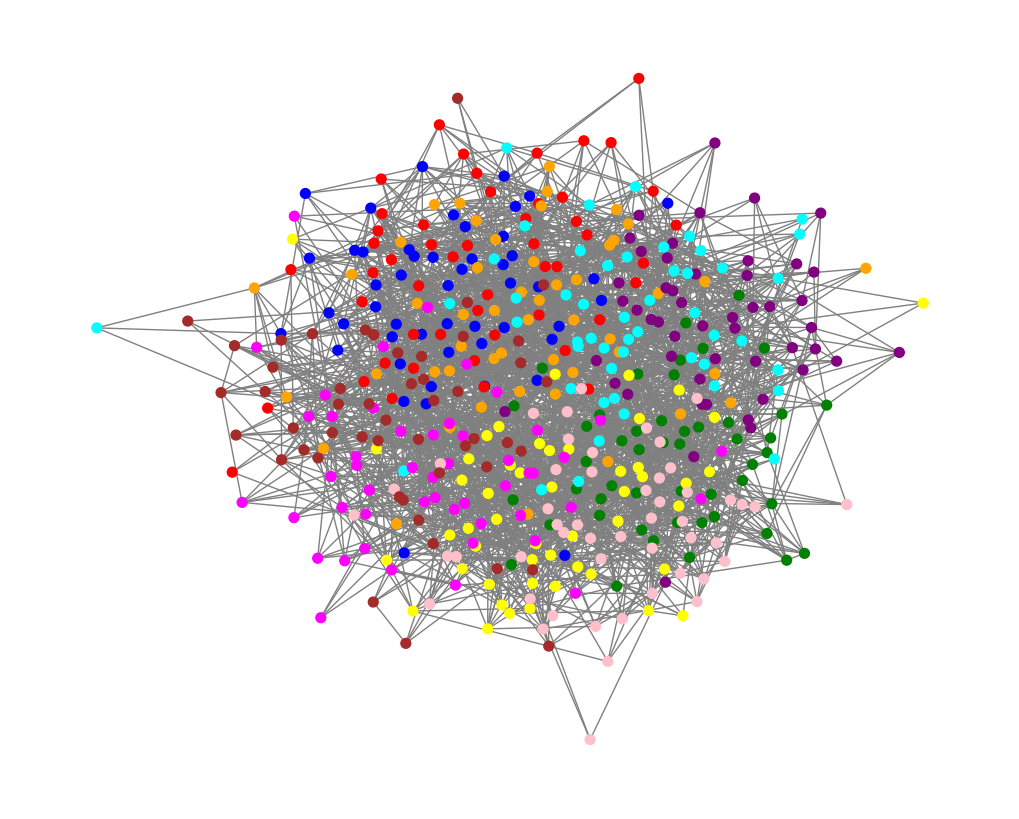

In [19]:
node_colors = [data['color'] for node, data in fb.nodes(data=True)]

plt.figure(figsize=(10, 8))
nx.draw(fb, node_color=node_colors, node_size=50, edge_color='gray')
plt.show()

In [20]:
# Political ranking randomised for now but needs to be related to the community structure somehow
rank = [-2, 1, 0, 1, 2]
for node in fb.nodes:
    fb.nodes[node]['politics'] = random.choice(rank)

In [21]:
fb.nodes(data=True)

NodeDataView({0: {'block': 0, 'color': 'blue', 'politics': 0}, 1: {'block': 0, 'color': 'blue', 'politics': 2}, 2: {'block': 0, 'color': 'blue', 'politics': 1}, 3: {'block': 0, 'color': 'blue', 'politics': 1}, 4: {'block': 0, 'color': 'blue', 'politics': 1}, 5: {'block': 0, 'color': 'blue', 'politics': 1}, 6: {'block': 0, 'color': 'blue', 'politics': 1}, 7: {'block': 0, 'color': 'blue', 'politics': 1}, 8: {'block': 0, 'color': 'blue', 'politics': 0}, 9: {'block': 0, 'color': 'blue', 'politics': 1}, 10: {'block': 0, 'color': 'blue', 'politics': 2}, 11: {'block': 0, 'color': 'blue', 'politics': 1}, 12: {'block': 0, 'color': 'blue', 'politics': 2}, 13: {'block': 0, 'color': 'blue', 'politics': 0}, 14: {'block': 0, 'color': 'blue', 'politics': -2}, 15: {'block': 0, 'color': 'blue', 'politics': 1}, 16: {'block': 0, 'color': 'blue', 'politics': 0}, 17: {'block': 0, 'color': 'blue', 'politics': 0}, 18: {'block': 0, 'color': 'blue', 'politics': 0}, 19: {'block': 0, 'color': 'blue', 'politics':

### Constructing the twitter network

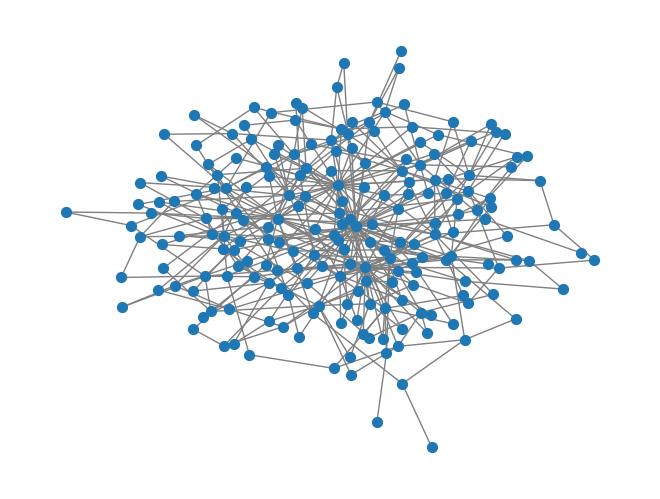

In [44]:
# Using a preferential attachment model
G = nx.barabasi_albert_graph(200, 2, seed=42)

for i in range(5):
    G.add_edge(200 + i, random.choice(list(G.nodes)))
    
    
nx.draw(G, node_size=50, edge_color='gray')

### Contagion model

In [37]:
# Function to determine probability of infection for a node given the politics and the mis_count

def infection_prob(politics, mis_count):
    probabilities = {-2: 0.01, -1: 0.10, 0: 0.20, 1: 0.50, 2: 0.75}
    
    adjusted_probabilities = {}
    for politics_val, prob in probabilities.items():
        adjusted_prob = prob - (mis_count * 0.005)
        
        # Ensure probability does not go below 0
        adjusted_prob = max(0, adjusted_prob)
        adjusted_probabilities[politics_val] = adjusted_prob
    
    # Return probability based on opinion
    return adjusted_probabilities[politics]

In [38]:
# Function currently works with people not being able to reshare. The simulation then stops in a period when no-one reshares
# Function will return the graph, where the infection status of the nodes will be an attribute
# Mis_count is currently handled sequentially (i.e. there will be different mis_count for different nodes in the same period). This needs to be considered.

def fake_news_spread(G):
    
    # Set all nodes to uninfected
    for node in G.nodes:
        G.nodes[node]['infected'] = False
    
    infected_nodes = set()
    t = 1
    mis_count = 0
    
    # Set to keep track of nodes who have added to misleading count
    mis_count_nodes = set()
    
    # Define probabilities of adding to misleading count
    mis_probs = {-2: 0.8, -1: 0.6, 0: 0.5, 1: 0.25, 2: 0.1}
    
    # Choose one node with politics=2 randomly to start the spread
    nodes_politics_2 = [node for node, attrs in G.nodes(data=True) if attrs['politics'] == 2]
    random_node = random.choice(nodes_politics_2)
    infected_nodes.add(random_node)
    G.nodes[random_node]['infected'] = True
    
    # Iterate over time periods until no new person spreads fake news
    new_infections = set()
    new_infections.add(random_node)
    while True:
        t += 1

        # Defining sets as new_infections cannot be updated during the loop
        nodes_to_remove = set()
        nodes_to_add = set()
        
        # Iterate over infected nodes and infect their neighbors with some probability defined by previous function
        for node in new_infections:
            # Remove node from infections so each node only has one chance to spread fake news
            nodes_to_remove.add(node)
            for neighbor in G.neighbors(node):
                if neighbor not in infected_nodes or new_infections:
                    p = infection_prob(G.nodes[neighbor]['politics'], mis_count)
                    if random.random() < p:
                        nodes_to_add.add(neighbor)
                        G.nodes[neighbor]['infected'] = True
                    # Else condition to see if they add to misleading count
                    else:
                        if neighbor not in mis_count_nodes:
                            mis_p = mis_probs[G.nodes[neighbor]['politics']]
                            if random.random() < mis_p:
                                mis_count += 1
                                mis_count_nodes.add(neighbor)
        
        # Remove all nodes which have shared fake news (as only one shot to infect)                
        new_infections.difference_update(nodes_to_remove)
        new_infections.update(nodes_to_add)
                              
        if not new_infections:
            break
            
        infected_nodes.update(new_infections)
        
    print("Simulation lasted " + str(t) + " periods")
    print("Missing count at end of simulation: " + str(mis_count))
    print("Number of people sharing fake news: " + str(len(infected_nodes)))
    
    return G

In [39]:
# Test on facebook graph
fb_sim = fake_news_spread(fb)

Simulation lasted 6 periods
Missing count at end of simulation: 179
Number of people sharing fake news: 65


This means that almost everyone ends up adding to the misleading count, but still half the people end up believeing the fake news. Should you be allowed to become infected if you previously added to the misleading count? Are the number of people sharing fake news all those who are on the right side of the political spectrum?